<h2> Making and using classification models </h2>

<p> Once data is labeled with the ImageSegmenter, a model needs to be trained for classification. </p>

In [29]:
import facet_ml.classification.model_training as mt
import facet_ml.classification.model_using as mu
from facet_ml.segmentation.segmenter import ImageSegmenter
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import os
import cv2
from pathlib import Path
import numpy as np

In [2]:
## Load some previously labeled training data
data_name = "2024_02_27_Processed.csv"
df_load = pd.read_csv(data_name)
df_load = mt.replace_and_clean_labels_df(
    df=df_load,
    replace={
        "C":"Crystal",
        "MC":"Fused Crystal",
        "I":"Incomplete",
        "PS":"Incomplete"
    }
)

# Check what it is loading in its Labels (targets) column
df_load["Labels"].value_counts()

Labels
Incomplete       1069
Crystal           573
Fused Crystal     346
Name: count, dtype: int64

In [3]:
# Create the model trainer with 5 splits in StratifiedKFold
myTrainer = mt.ModelTrainer(
             df_load,
             model_class=RandomForestClassifier,
             features="default_features", # Grabs from our "default_features" config file
             model_params="original", # Grabs from our "original" model_params information for a RandomForest
             labels=["Crystal","Fused Crystal", "Incomplete"],
             n_splits=5
             )

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


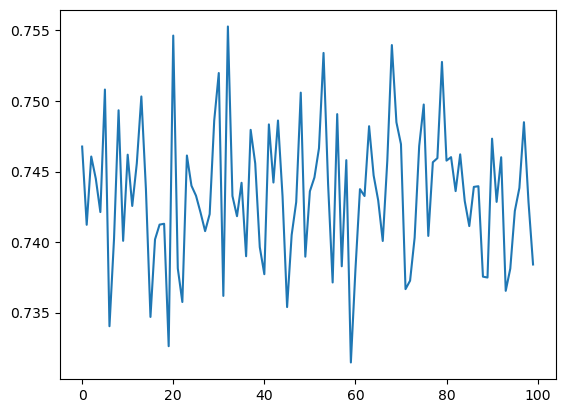

In [4]:
# Train 100 iterations of the model
logged_f1s = myTrainer.best_model_loop(100)

# Check average kfold performance
x = list(range(len(logged_f1s)))
plt.plot(x,logged_f1s)

In [5]:
model:RandomForestClassifier = myTrainer.best_run_dict["model"]

<h2> Applying the model </h2>
<p> To help make use of the model with ImageSegmenters, a ModelApplication tool is used. </p>

([], [])

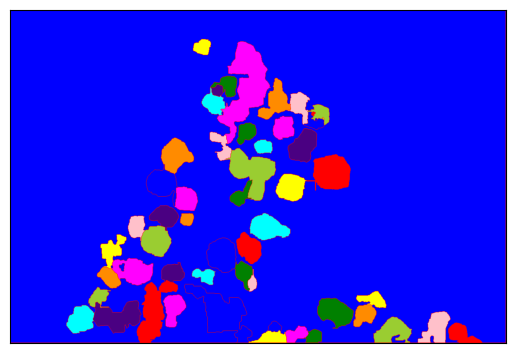

In [31]:
# Define an Image to open
working_dir = Path(os.path.abspath(""))
image_dir = working_dir.parent / "Images"
image_paths = list(image_dir.rglob("*"))
image_path_oi = str(image_paths[0])

image = cv2.imread(image_path_oi,0)
plt.imshow(image)

IS = ImageSegmenter(input_path=image_path_oi)
plt.imshow(IS.image_labeled); plt.xticks([]); plt.yticks([])


<p> The model can be loaded in with the relevant ImageSegmenter and used to get the labels for each Region </p>
<p> NOTE: This dataset was segmented using SegmentAnything, and this ImageSegmenter is simple Otsu binarization. </p>

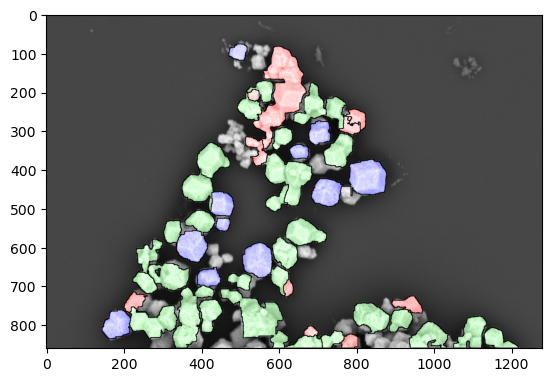

In [30]:
model_app = mu.ModelApplication(model,
                                image_segmenter=IS,
                                features=list(model.feature_names_in_))
IS.df["Labels"] = model_app.run()
color_image = mu.visualize_labels(IS,
                                  IS.df,
                                  color_dict={ 
                                      "Crystal": np.array([0, 0, 255]),
                                      "Fused Crystal": np.array([0, 100, 0]),
                                      "Incomplete": np.array([255, 0, 0])
                                  }
                                  )
plt.imshow(color_image)